# Solve Linear System from Finite Differences Poisson Equation in 2D

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg
import scipy.optimize
import matplotlib.pylab as plt

## Build Functions

In [2]:
def buildA(N):
    dx = 1 / N
    nvar = (N - 1)**2;
    e1 = np.ones((nvar), dtype=float);
    e2 = np.copy(e1)
    e2[::N-1] = 0
    e3 = np.copy(e1)
    e3[N-2::N-1] = 0
    A = sp.spdiags(
        (-e1, -e3, 4*e1, -e2, -e1),
        (-(N-1), -1, 0, 1, N-1), nvar, nvar
    )
    A = A / dx**2;
    return A

In [3]:
def buildf1(N):
    x = np.arange(0, 1, 1/N).reshape(N, 1)
    y = x.T
    f = np.dot(np.sin(np.pi*x), np.sin(np.pi*y))
    return f[1:,1:].reshape(-1,1)

In [4]:
def buildf2(N):
    x = np.arange(0, 1, 1/N).reshape(N, 1)
    y = x.T
    f = np.dot(np.maximum(x,1-x), np.maximum(y,1-y))
    return f[1:,1:].reshape(-1, 1)

## Solve using Jacobi

In [5]:
def solve_jacobi(A, b, x0=None, tolerance = 1e-5, max_iterations=100):
    if x0 is None:
        x = np.zeros_like(b)
    else:
        x = np.copy(x0)
    b_norm = np.linalg.norm(b)
    
    D = A.diagonal().reshape(-1, 1)
    D_inv = 1/D

    for i in range(max_iterations):
        r = b - A@x

        err = np.linalg.norm(r) / b_norm
        if (err < tolerance):
            break
        
        x += D_inv * r
    return x, i

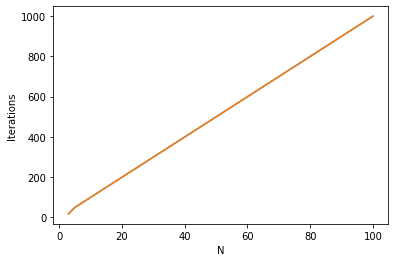

In [6]:
reps = 20
iterations = np.empty((reps, 2), dtype=int)
Ns = np.logspace(0.5, 2, reps, dtype=int)
for j, buildf in enumerate([buildf1, buildf2]):
    for i, N in enumerate(Ns):
        A = buildA(N)
        f = buildf(N)
        max_iters = 10*N
        x, iters = solve_jacobi(A, f, max_iterations=max_iters)
        if iters < max_iters:
            iterations[i,j] = iters

plt.plot(Ns, iterations)
plt.xlabel('N')
plt.ylabel('Iterations')
plt.show()

## Solve using SOR Method

In [7]:
def SOR(A, b, omega, x0=None, tolerance=1e-5, max_iterations=100):
    if x0 is None:
        x = np.zeros_like(x0)
    else:
        x = np.copy(x0)
    b_norm = np.linalg.norm(b)

    D = sp.spdiags((A.diagonal()), (0), *A.shape)
    L = sp.tril(A, k=-1)
    M = (1/omega) * D + L

    for i in range(max_iterations):
        r = b - A@x
        err = np.linalg.norm(r) / b_norm
        if (err < tolerance):
            break
        x += scipy.sparse.linalg.spsolve_triangular(M, r)
    return x, i

In [8]:
N = 64
A = buildA(N)
f = buildf2(N)